# Electronic Vehicle Population Market Analysis


In [36]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

# Data Frame Overview

In [37]:
df = pd.read_csv(r"C:\Users\Emily\OneDrive\Desktop\Online Dataset\Kaggle Dataset\Electric_Vehicle_Population_Data.csv")
df.shape


(159467, 17)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159467 entries, 0 to 159466
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         159467 non-null  object 
 1   County                                             159463 non-null  object 
 2   City                                               159463 non-null  object 
 3   State                                              159467 non-null  object 
 4   Postal Code                                        159463 non-null  float64
 5   Model Year                                         159467 non-null  int64  
 6   Make                                               159467 non-null  object 
 7   Model                                              159467 non-null  object 
 8   Electric Vehicle Type                              159467 non-null  object

# Engineering

### Counting NULLs

In [39]:
nan_count = df.isna().sum()
nan_count

VIN (1-10)                                             0
County                                                 4
City                                                   4
State                                                  0
Postal Code                                            4
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Base MSRP                                              0
Legislative District                                 361
DOL Vehicle ID                                         0
Vehicle Location                                       9
Electric Utility                                       4
2020 Census Tract                                      4
dtype: int64

### Extract Longtitude and Latitude from Vehicale Location

In [45]:
# Convert the 'Vehicle Location' column to string type
df['Vehicle Location'] = df['Vehicle Location'].astype(str)

# Extract the latitude and longitude from the 'Vehicle Location' column
def extract_coordinates(x, index):
    # remove POINT and Parenthese and split by space
    remove_string = x.replace("POINT (", "").replace(")", "")
    coords = remove_string.split()

    # Ensure there are exactly two coordinates, then return the one based on index
    if len(coords) == 2:
        return float(coords[index])  # index 0 for longitude, index 1 for latitude
    else:
        return None
# POINT (-122.5235781 47.6293323)
#-122.5235781 47.6293323
#['-122.5235781', '47.6293323']
df['latitude'] = df['Vehicle Location'].apply(lambda x: extract_coordinates(x, 0))
df['longitude'] = df['Vehicle Location'].apply(lambda x: extract_coordinates(x, 1))

# Drop any NULLs value does not have Location. Balance the shape of the Dataframe
df = df.dropna(subset=['latitude', 'longitude'])

In [43]:
df['latitude'].head()

0   -122.646627
1   -117.904310
2   -120.602720
3   -122.523578
4   -122.896920
Name: latitude, dtype: float64

In [44]:
df['longitude'].head()

0    47.634119
1    48.547075
2    46.596562
3    47.629332
4    47.043535
Name: longitude, dtype: float64

### Combine County, City and State into one column Location

In [42]:
df['Location'] = df['County'] + ', ' + df['City'] + ', ' + df['State']
df['Location'].head()

0            Kitsap, Bremerton, WA
1            Stevens, Colville, WA
2               Yakima, Yakima, WA
3    Kitsap, Bainbridge Island, WA
4           Thurston, Tumwater, WA
Name: Location, dtype: object

### Create a Distribution Graph for Base MSRP

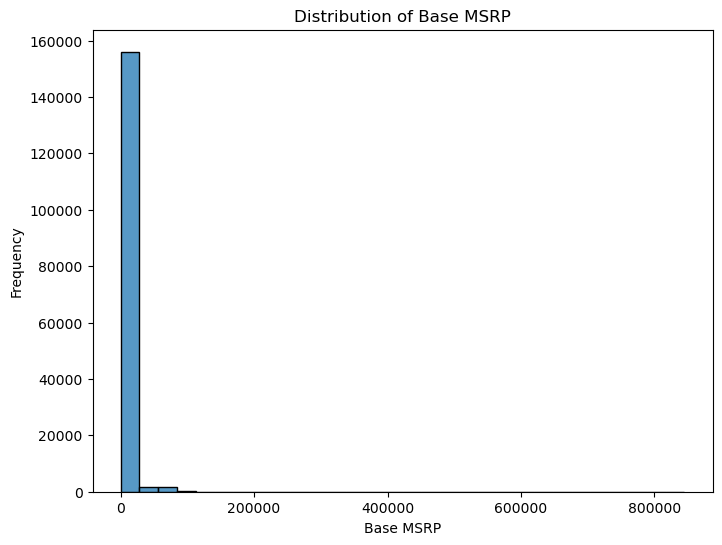

In [8]:
plt.figure(figsize=(8, 6))
sns.histplot(df["Base MSRP"], bins=30)
plt.title("Distribution of Base MSRP")
plt.xlabel("Base MSRP")
plt.ylabel("Frequency")
plt.show()

A lot of Data are having 0 Base MSRP

### Create Logical Condition for column Base MSRP 
- (-1) to 0 is UNKNOWN
- 0 to 4000 is LOW
- 4000 to 6000 is MEDIUM
- Over 6000 is HIGH 

In [46]:
def price_range_category(df, column='Base MSRP'):
    bins = [-1, 0, 40000, 60000, float('inf')]  # Define the boundaries for the categories
#bins: Defines the price ranges (from -1 to account for zero prices).
#[-1, 0]: Corresponds to "Unknown".
#(0, 40000]: Corresponds to "Low".
#(40000, 60000]: Corresponds to "Medium".
#60000+: Corresponds to "High".
    labels = ['Unknown', 'Low', 'Medium', 'High']  # Corresponding category labels
    # pd.cut(): Automatically bins the prices into these categories based on the defined bins.
    df['Price Range Category'] = pd.cut(df[column], bins=bins, labels=labels, right=False)
    return df

# Since we are having way too much UNKNOW MSRP. I decided to filter ONLY to UNKNOWN
df = price_range_category(df, column='Base MSRP')

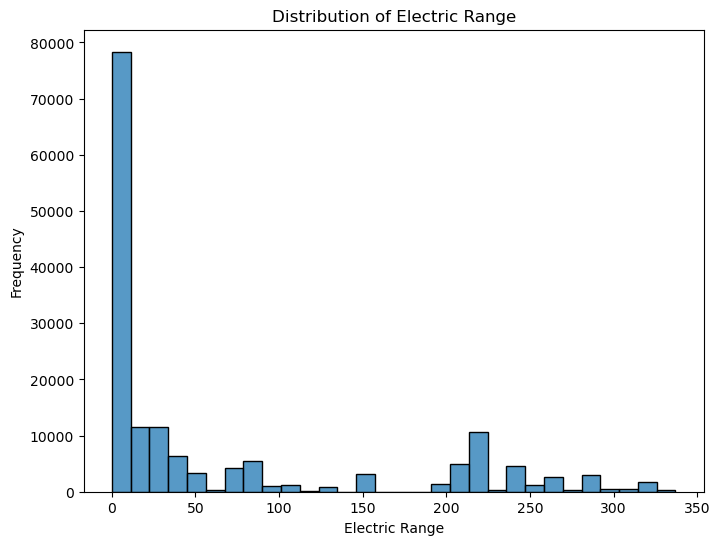

In [47]:
plt.figure(figsize=(8, 6))
sns.histplot(df["Electric Range"], bins=30)
plt.title("Distribution of Electric Range")
plt.xlabel("Electric Range")
plt.ylabel("Frequency")
plt.show()

### Create Logical Condition for column Electric Range
- Less than 0 is UNKNOWN
- 0 to 40000 is LOW
- 40,000 to 60,000 is MEDIUM
- OVER 60,000 is HIGH 

In [57]:
def electric_range_category(df, column='Electric Range'):
    bins = [-float('inf'), 0, 150, 300, float('inf')]  # Define the boundaries for the categories
# bins: Specifies the boundaries for each category:
#-float('inf') to 0 for "Unknown".
#0 to 40000 for "Low".
#40000 to 60000 for "Medium".
#60000 to infinity for "High".
    labels = ['Unknown', 'Short', 'Medium', 'Long']  # Corresponding category labels
    df['Electric Range Category'] = pd.cut(df[column], bins=bins, labels=labels, right=False)
    return df
    
# Add column electric_range_category into df
df = electric_range_category(df, column='Electric Range')

### What is the top Model in each Electric Range

In [56]:
# Grouping by Model and Electric Range, counting, and sorting by Electric Range and then by Count
grouped_df_by_model_and_er = (
    df.groupby(['Model', 'Electric Range'])
    .size()
    .reset_index(name='Count')
    .sort_values(by=['Electric Range', 'Count'], ascending=[False, False])  # Sort by Electric Range and then Count in descending order
)

# Selecting the top 10 results
top_10_by_er_and_count = grouped_df_by_model_and_er.head(10)
top_10_by_er_and_count


,Model,Electric Range,Count
144,MODEL S,337,76
143,MODEL S,330,318
136,MODEL 3,322,1744
135,MODEL 3,308,526
149,MODEL X,293,451
151,MODEL Y,291,2255
148,MODEL X,289,644
142,MODEL S,270,269
134,MODEL 3,266,1471
141,MODEL S,265,129


### Insights:
- Testa is dominating with all models having the Longest Electric Range
- MODEL Y is the Longest Electric Range

# EDA

In [75]:
### Picked or Filtered only columns that are necessary for modeling
df = df[['Location', 'State', 'Model Year','Make', 'Model', 'Electric Vehicle Type','Clean Alternative Fuel Vehicle (CAFV) Eligibility',
         'Electric Range Category', 'Price Range Category']]
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 159458 entries, 0 to 159466
Data columns (total 9 columns):
 #   Column                                             Non-Null Count   Dtype   
---  ------                                             --------------   -----   
 0   Location                                           159458 non-null  object  
 1   State                                              159458 non-null  object  
 2   Model Year                                         159458 non-null  int64   
 3   Make                                               159458 non-null  object  
 4   Model                                              159458 non-null  object  
 5   Electric Vehicle Type                              159458 non-null  object  
 6   Clean Alternative Fuel Vehicle (CAFV) Eligibility  159458 non-null  object  
 7   Electric Range Category                            159458 non-null  category
 8   Price Range Category                               159458 non-null  ca

### Distribution of State by Counts

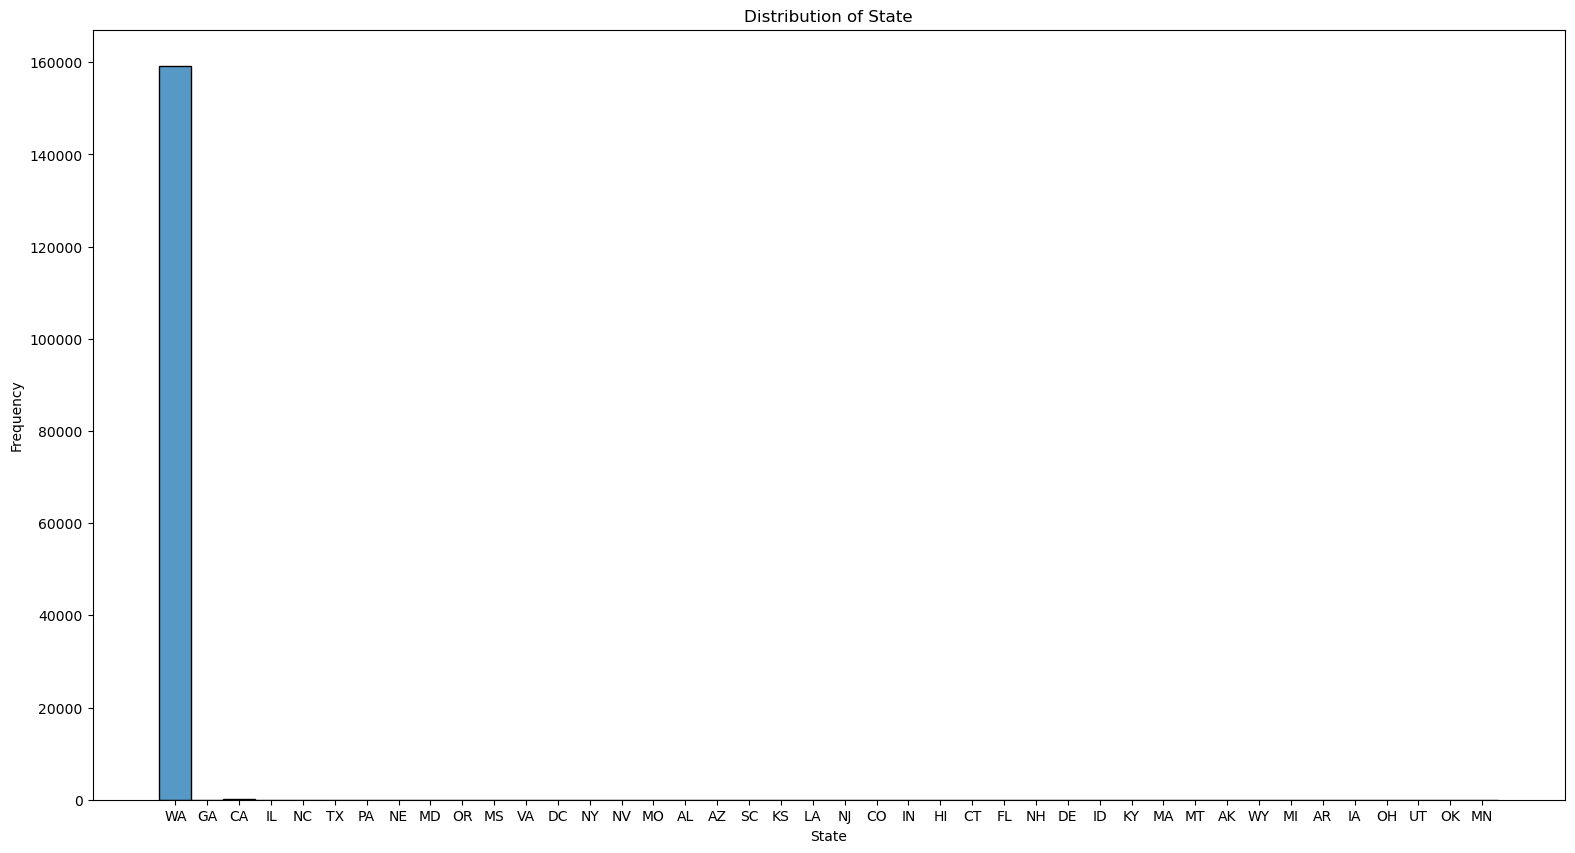

In [76]:
plt.figure(figsize=(19, 10))
sns.histplot(df["State"], bins=60)
plt.title("Distribution of State")
plt.xlabel("State")
plt.ylabel("Frequency")
plt.show()

- There are so many data in WA
- It is best to filter only in WA State

In [77]:
# Filter to only WA
filtered_df = df[ (df["State"] == "WA")]

### Top 10 make in Electric Vehicle 

In [78]:
top_10_make_using_ev = filtered_df.groupby(['Make']).size().sort_values(ascending=False).head(10)
top_10_make_using_ev

Make
TESLA         72274
NISSAN        13780
CHEVROLET     12542
FORD           7988
BMW            6828
KIA            6741
TOYOTA         5505
VOLKSWAGEN     4415
VOLVO          3737
JEEP           3679
dtype: int64

### Data Filtering based on Preference

- Filter Data to top 10 Makes 

In [79]:
filtered_df = filtered_df[filtered_df['Make'].isin(['TESLA', 'NISSAN', 'CHEVROLET', 'FORD', 'BMW', 'KIA', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO', 'MERCEDES-BENZ'])]
set(filtered_df['Make'])

{'BMW',
 'CHEVROLET',
 'FORD',
 'KIA',
 'MERCEDES-BENZ',
 'NISSAN',
 'TESLA',
 'TOYOTA',
 'VOLKSWAGEN',
 'VOLVO'}

- Filter Data to only 2022 and 2023
- I want to analyze most recent Data 
- 2024 has limited information so I wont include them into this DF

In [80]:
# set(filtered_data['Model Year'])
filtered_df = filtered_df[filtered_df['Model Year'].isin([2023, 2022])]
filtered_df.head(5)

,Location,State,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range Category,Price Range Category
2,"Yakima, Yakima, WA",WA,2022,KIA,EV6,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,Short,Low
7,"Yakima, Yakima, WA",WA,2022,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,Short,Low
15,"Snohomish, Bothell, WA",WA,2022,VOLVO,XC90,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,Short,Low
18,"Whitman, Pullman, WA",WA,2022,NISSAN,LEAF,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,Short,Low
43,"Snohomish, Lake Stevens, WA",WA,2023,BMW,530E,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,Short,Low


### What location is using the most EV ? 

In [81]:
# Display top 20 location using EV
top_10_location_using_ev = filtered_df.groupby(['Location']).size().sort_values(ascending=False).head(10)

# Converting the Series to a DataFrame and resetting the index
top_10_location_using_ev = top_10_location_using_ev.reset_index()
top_10_location_using_ev.columns = ['Location', 'Count']  # Renaming columns for clarity


top_10_location_using_ev


,Location,Count
0,"King, Seattle, WA",8959
1,"King, Bellevue, WA",3500
2,"King, Redmond, WA",2586
3,"King, Sammamish, WA",2103
4,"Snohomish, Bothell, WA",2050
5,"Clark, Vancouver, WA",1962
6,"King, Kirkland, WA",1865
7,"King, Renton, WA",1718
8,"Thurston, Olympia, WA",1314
9,"Pierce, Tacoma, WA",1180


### Percentage of Total in Top 10 Location using EV

In [82]:
# Calculating the percentage for each location
total_count = top_10_location_using_ev['Count'].sum()
top_10_location_using_ev['Percentage'] = (top_10_location_using_ev['Count'] / total_count) * 100

top_10_location_using_ev

,Location,Count,Percentage
0,"King, Seattle, WA",8959,32.892756
1,"King, Bellevue, WA",3500,12.850167
2,"King, Redmond, WA",2586,9.494438
3,"King, Sammamish, WA",2103,7.721115
4,"Snohomish, Bothell, WA",2050,7.526526
5,"Clark, Vancouver, WA",1962,7.203437
6,"King, Kirkland, WA",1865,6.847303
7,"King, Renton, WA",1718,6.307596
8,"Thurston, Olympia, WA",1314,4.824320
9,"Pierce, Tacoma, WA",1180,4.332342


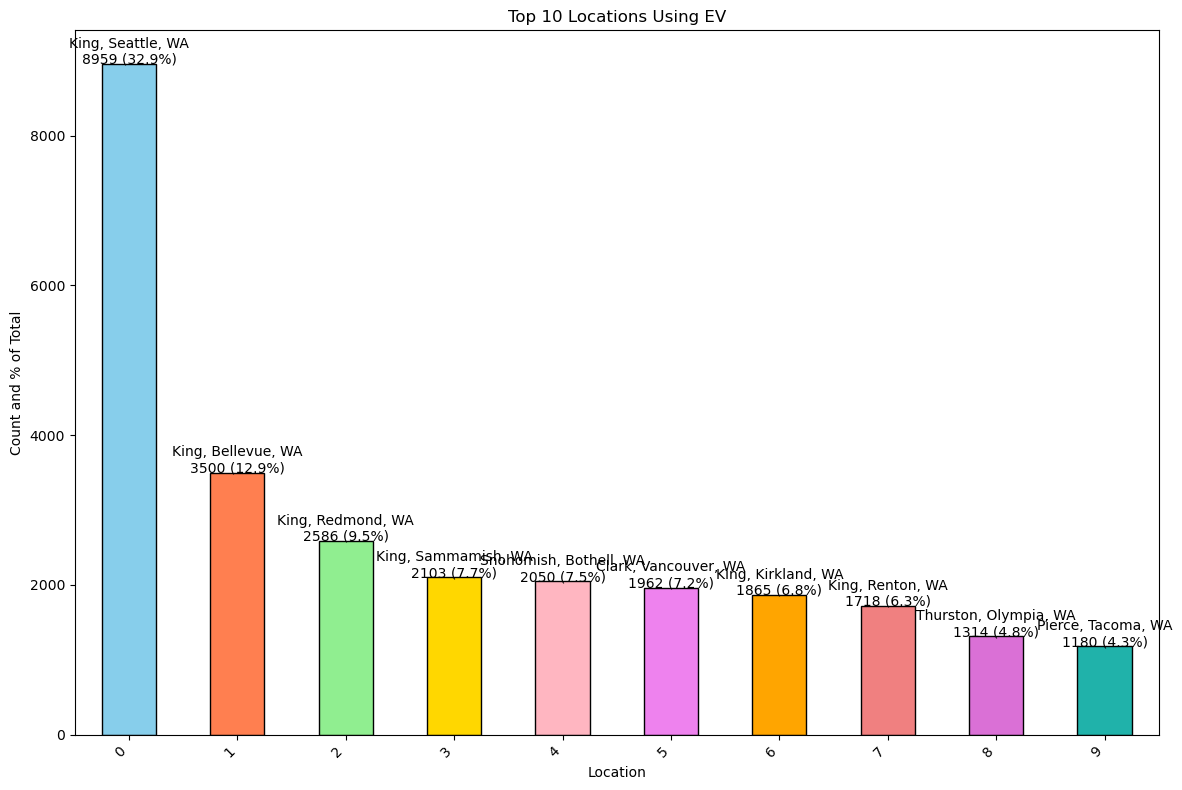

In [83]:
# Defining a list of colors for the bars
colors = ['skyblue', 'coral', 'lightgreen', 'gold', 'lightpink', 'violet', 'orange', 
          'lightcoral', 'orchid', 'lightseagreen', 'plum', 'palegoldenrod', 'deepskyblue', 
          'salmon', 'turquoise', 'khaki', 'mediumspringgreen', 'peachpuff', 'lavender', 'lightsteelblue']

# Plotting the bar graph with custom colors
plt.figure(figsize=(12, 8))
ax = top_10_location_using_ev['Count'].plot(kind='bar', color=colors[:len(top_10_location_using_ev)], edgecolor='black')

# Adding percentage values on the bars
for index, value in enumerate(top_10_location_using_ev['Count']):
    location = top_10_location_using_ev['Location'].iloc[index]
    percentage = top_10_location_using_ev['Percentage'].iloc[index]
    ax.text(index, value + 1, f'{location}\n{value} ({percentage:.1f}%)', ha='center')

# Adding labels and title
plt.title('Top 10 Locations Using EV')
plt.xlabel('Location')
plt.ylabel('Count and % of Total')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Insights
- King County in each city always have higher EV usage.
- Capita Income in King County is $113,000. Higher than average income from WA. ($75,000). 
- Seattle and Bellevue are 2 cities having the most EV. 
- Higher Income Class prefer to use EV. This is explained in several reasons such as Lifestyle, High-Tech Features and Enviromental Awareness. 

### What car make is using the Clean Energy ? 

In [84]:
contingency_table = pd.crosstab(filtered_df['Make'], filtered_df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'])
contingency_table

Clean Alternative Fuel Vehicle (CAFV) Eligibility,Clean Alternative Fuel Vehicle Eligible,Eligibility unknown as battery range has not been researched,Not eligible due to low battery range
Make,,,
BMW,1114,1206,270
CHEVROLET,0,3147,0
FORD,296,3235,0
KIA,1368,2987,165
MERCEDES-BENZ,0,838,0
NISSAN,0,2135,0
TESLA,0,35866,0
TOYOTA,976,178,182
VOLKSWAGEN,0,2361,0


- Visualization of Table showing counts of Make and CAFV

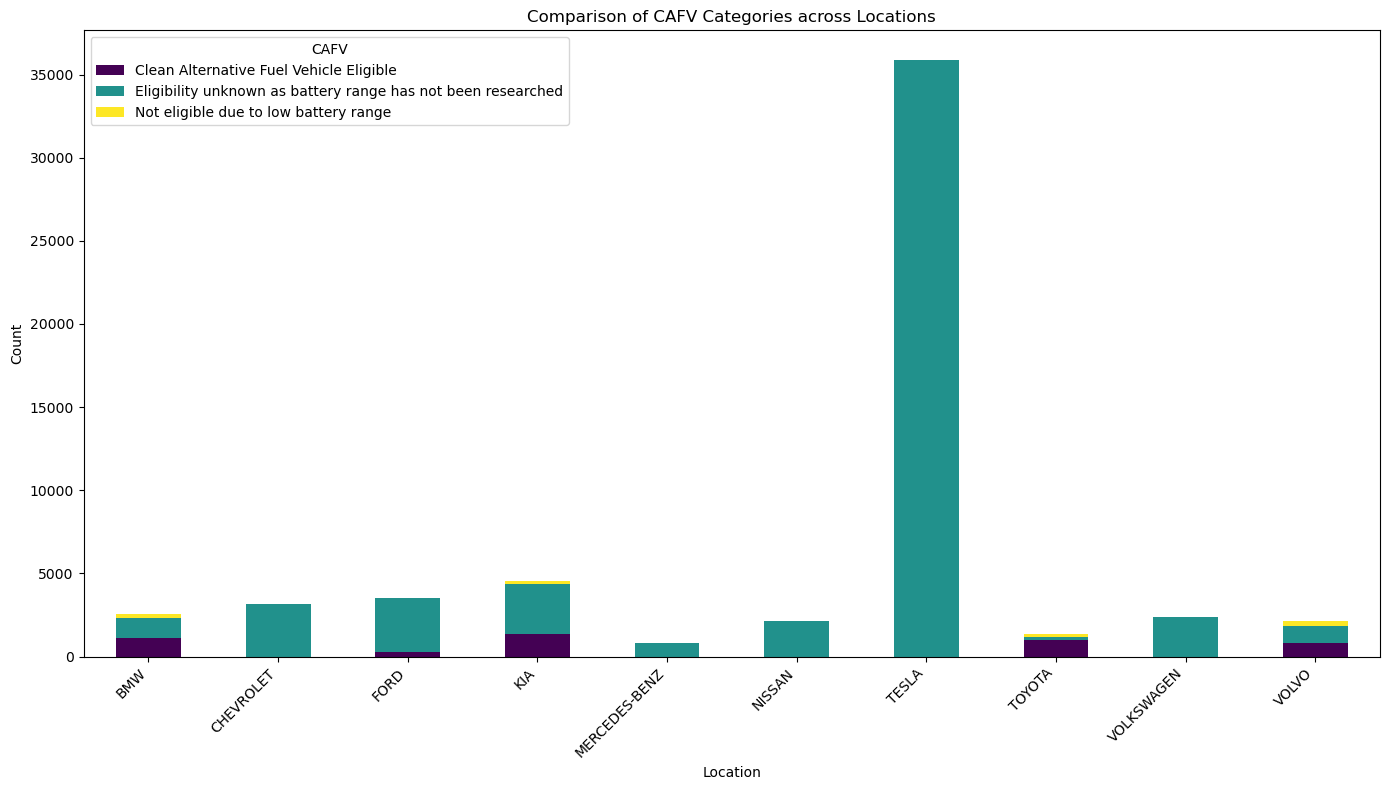

In [85]:
# Plotting the contingency table as a stacked bar chart
contingency_table.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')

plt.title('Comparison of CAFV Categories across Locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.legend(title='CAFV')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Insights:
- Although TESLA is the most popular car make, their Battery is not tested for Clean Research. 
- TESTLA is becoming an Energy company. This could be one of their strategy to hide their company information 
- TOYOTA and BMW are top 2 Car Make having the Cleanest Battery 
- Although there are not a lot of low battery range, the big majority of car having UNKNOWN battery range or not yet Researched is still very high. 
- This might be not efficient use for Environment Clean. 

### Comparison in How popular of Car Make and Model Year among each Make:

In [86]:
# Grouping by Model Year and Make, then counting and sorting by Count in descending order
grouped_df_by_model_and_make = (
    filtered_df.groupby(['Make','Model Year'])
    .size()
    .reset_index(name='Count')
    .sort_values(by='Make', ascending=False)
    
)

grouped_df_by_model_and_make

,Make,Model Year,Count
19,VOLVO,2023,1119
18,VOLVO,2022,1003
17,VOLKSWAGEN,2023,1651
16,VOLKSWAGEN,2022,710
15,TOYOTA,2023,762
14,TOYOTA,2022,574
13,TESLA,2023,22102
12,TESLA,2022,13764
11,NISSAN,2023,1177
10,NISSAN,2022,958


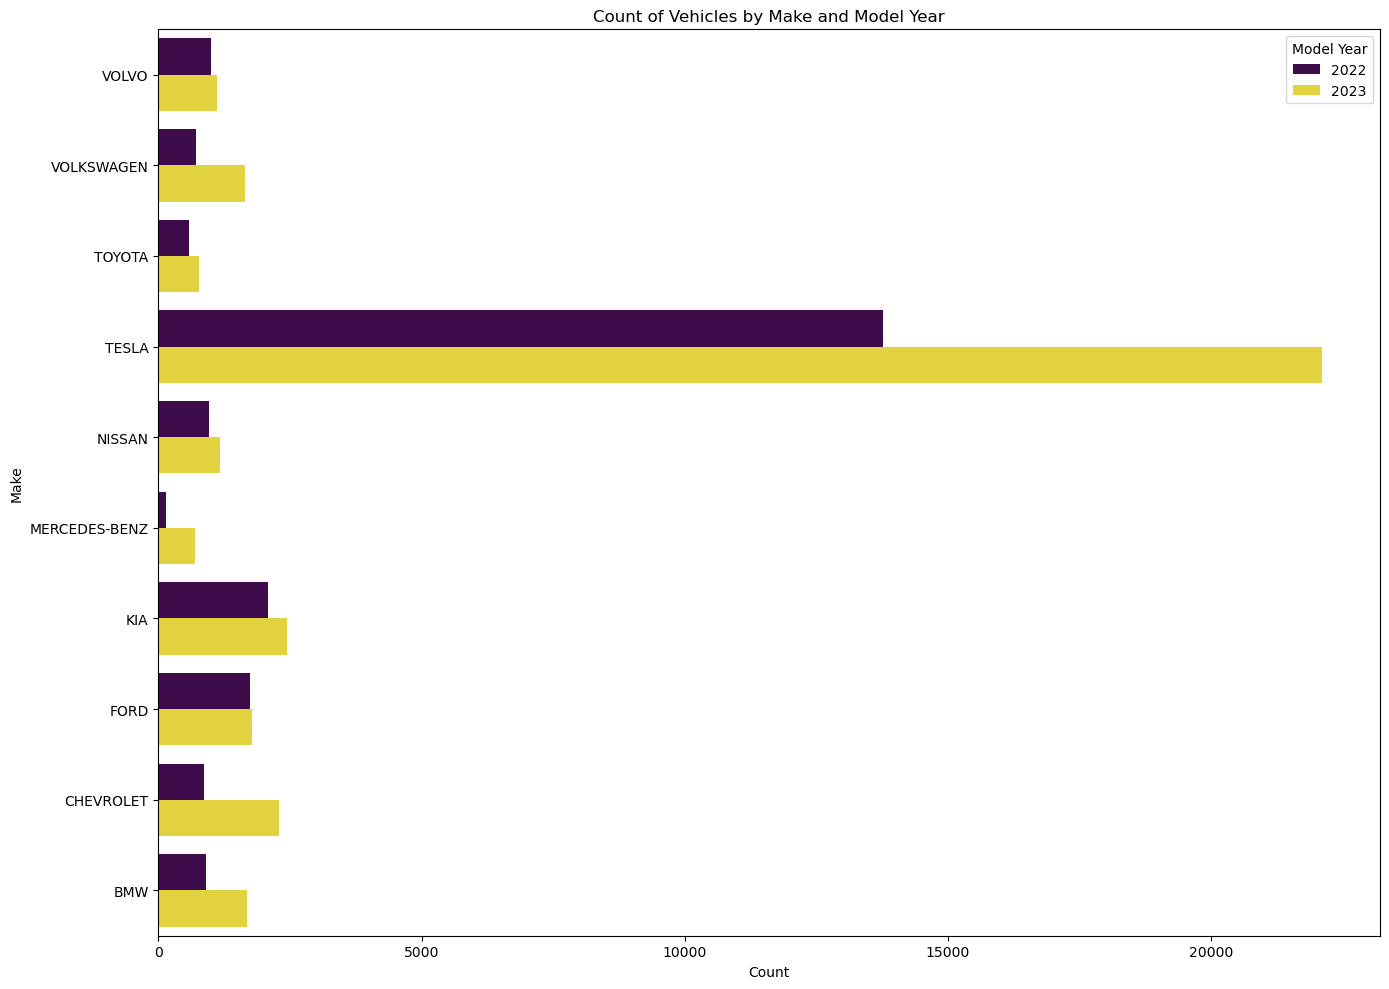

In [87]:
# Setting up the figure
plt.figure(figsize=(14, 10))

# Creating the horizontal bar plot
sns.barplot(
    data=grouped_df_by_model_and_make, 
    x='Count', 
    y='Make', 
    hue='Model Year', 
    palette='viridis'
)

# Adding labels and title
plt.title('Count of Vehicles by Make and Model Year')
plt.xlabel('Count')
plt.ylabel('Make')
plt.legend(title='Model Year', loc='upper right')
plt.tight_layout()
plt.show()

### Insights:
- Demand using EV increased significantly from 2022 to 2023

### How EV Demands increase from 2022 to 2023

In [88]:
# Grouping by Make and Model Year, counting each group
grouped_data_unstack = (
    filtered_df.groupby(['Make', 'Model Year'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
grouped_data_unstack

# Calculate the percentage difference
grouped_data_unstack['Percent Difference'] = (
    (grouped_data_unstack[2023] - grouped_data_unstack[2022]) / grouped_data_unstack[2022].replace(0, pd.NA) * 100
)

# Reset index to make it a regular DataFrame
result_df = grouped_data_unstack.reset_index()

# Display the result
print(result_df)

Model Year  index           Make   2022   2023  Percent Difference
0               0            BMW    904   1686           86.504425
1               1      CHEVROLET    864   2283          164.236111
2               2           FORD   1749   1782            1.886792
3               3            KIA   2074   2446           17.936355
4               4  MERCEDES-BENZ    149    689          362.416107
5               5         NISSAN    958   1177           22.860125
6               6          TESLA  13764  22102           60.578320
7               7         TOYOTA    574    762           32.752613
8               8     VOLKSWAGEN    710   1651          132.535211
9               9          VOLVO   1003   1119           11.565304


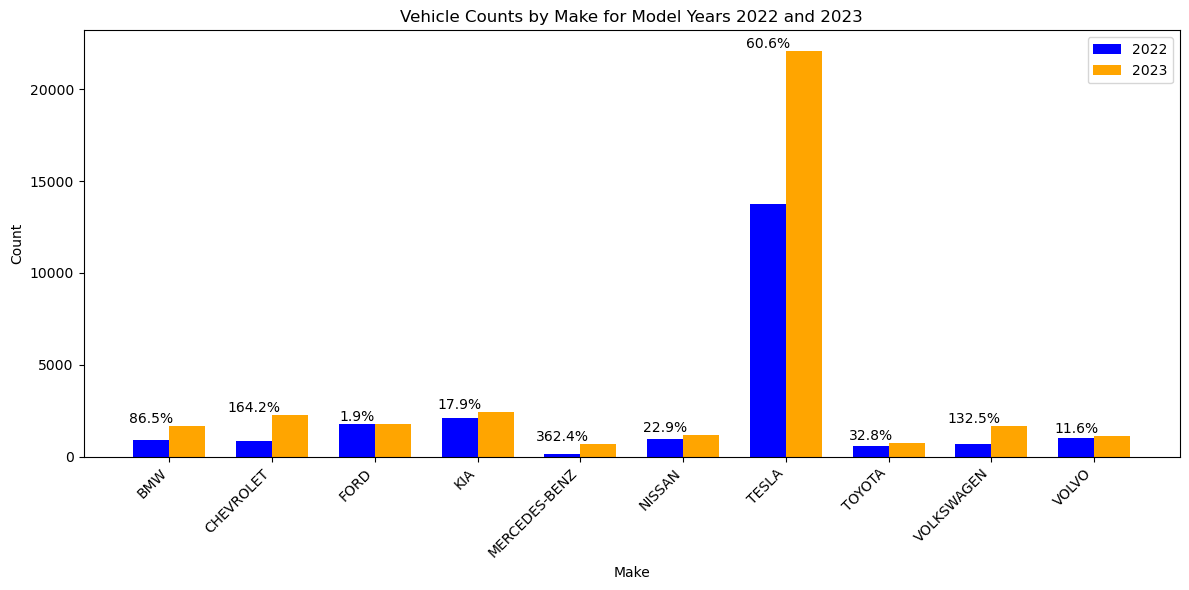

In [89]:
# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
index = np.arange(len(result_df))

# Create the figure and axis
plt.figure(figsize=(12, 6))

# Plotting the bars for 2022 and 2023
bar1 = plt.bar(index, result_df[2022], bar_width, label='2022', color='blue')
bar2 = plt.bar(index + bar_width, result_df[2023], bar_width, label='2023', color='orange')

# Adding labels and title
plt.xlabel('Make')
plt.ylabel('Count')
plt.title('Vehicle Counts by Make for Model Years 2022 and 2023')
plt.xticks(index + bar_width / 2, result_df['Make'], rotation=45, ha='right')
plt.legend()

# Optional: Add percentage difference as text on the bars
for i in index:
    plt.text(i, result_df[2023][i] + 0.5, f"{result_df['Percent Difference'][i]:.1f}%", ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

### Insights:
- TESLA is dominating EV with highes user counts and the YOY % increase 60%. It is very impressive due to the high users from 2022. 
- Other Car Makes are also targeting to EV market. BMW, CHEVROLET, MERCERDES-BENZ and VOLKSWAGEN are top 4 car makes having the highest YOY. 
- FORD and VOLVO seems very slow to this trend and not interested. FORD is famous for strong and powerful truck. It could be reason why they do not want to focus on this EV market. 
- Asian Car Makes are slow in sale from 2022 to 2023. (NISSAN, TOYOTA - JAPAN), (KIA - KOREA)

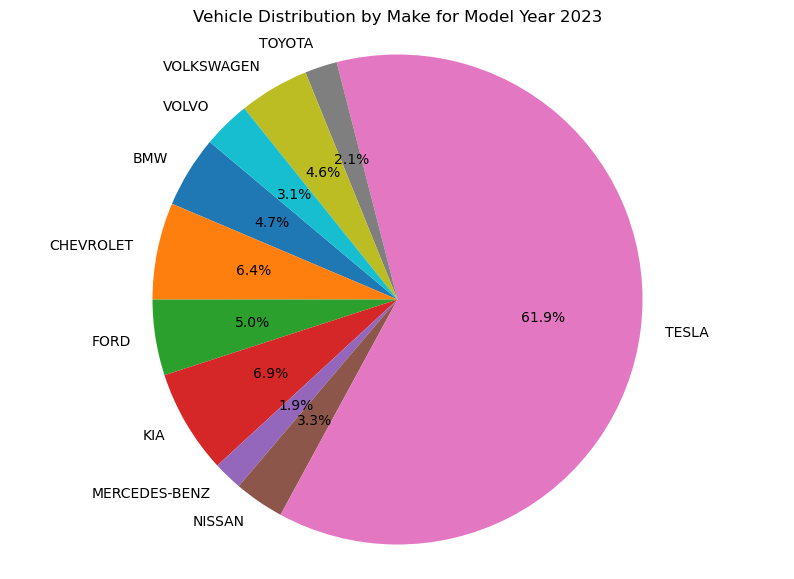

In [90]:
# Select data for the model year 2023
data_2023 = grouped_data_unstack.set_index('Make')[2023]

# Plotting the pie chart
plt.figure(figsize=(10, 7))
plt.pie(data_2023, labels=data_2023.index, autopct='%1.1f%%', startangle=140)
plt.title('Vehicle Distribution by Make for Model Year 2023')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()

### Insights:
- KIA contributed 6.9%. Top 2 in User Counts. Decreased from 2022 to 2023 but still contributed top 2. YOY sells still increases. 
- CHEVOLET has the most impressive improvements in sale. Increase 169% from 2022 and contributed to top 3. 
- FORD is rank 4. Very small YOY. 

### Top 20 EV Model

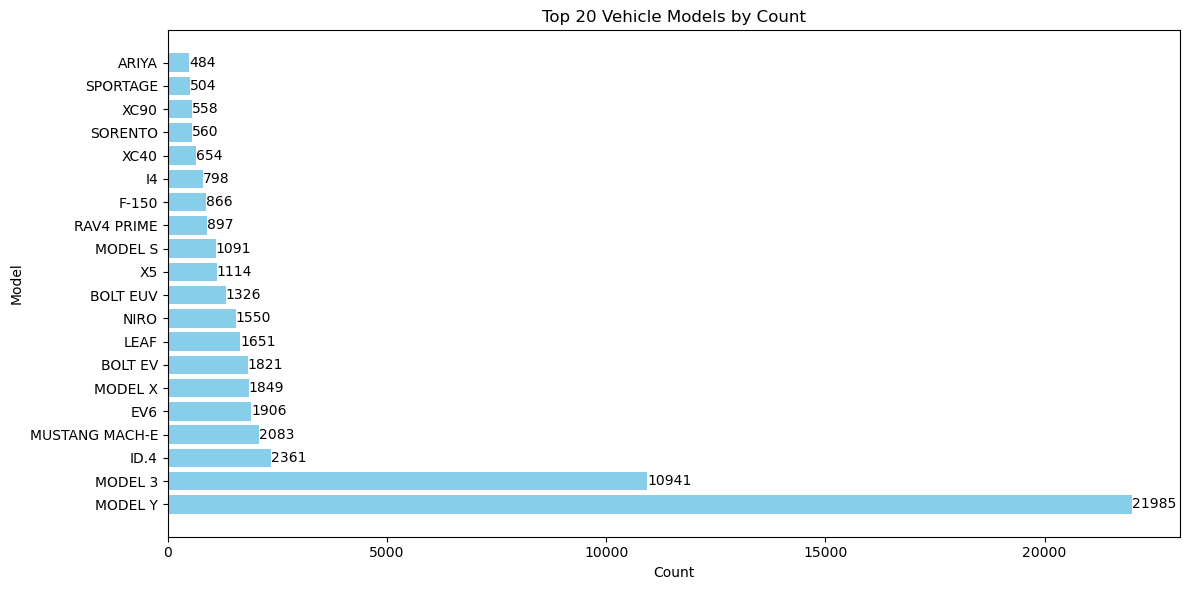

In [91]:
# Grouping by Model and Make, counting occurrences
top_20_model = (
    filtered_df.groupby(['Model', 'Make'])
    .size()
    .reset_index(name='Count')  
    .sort_values(by='Count', ascending= False)  
    .head(20)  # Get the top 20
)
top_20_model

models = top_20_model['Model']
counts = top_20_model['Count']

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Create the horizontal bar graph
bars = plt.barh(models, counts, color='skyblue')

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Model')
plt.title('Top 20 Vehicle Models by Count')

# Adding count labels on each bar
for bar in bars:
    plt.text(
        bar.get_width(),  # x position (width of the bar)
        bar.get_y() + bar.get_height() / 2,  # y position (center of the bar)
        '{:.0f}'.format(bar.get_width()),
        va='center'  # vertical alignment
    )

# Show the plot
plt.tight_layout()
plt.show()

### Battery vs Hybrid Vehicle

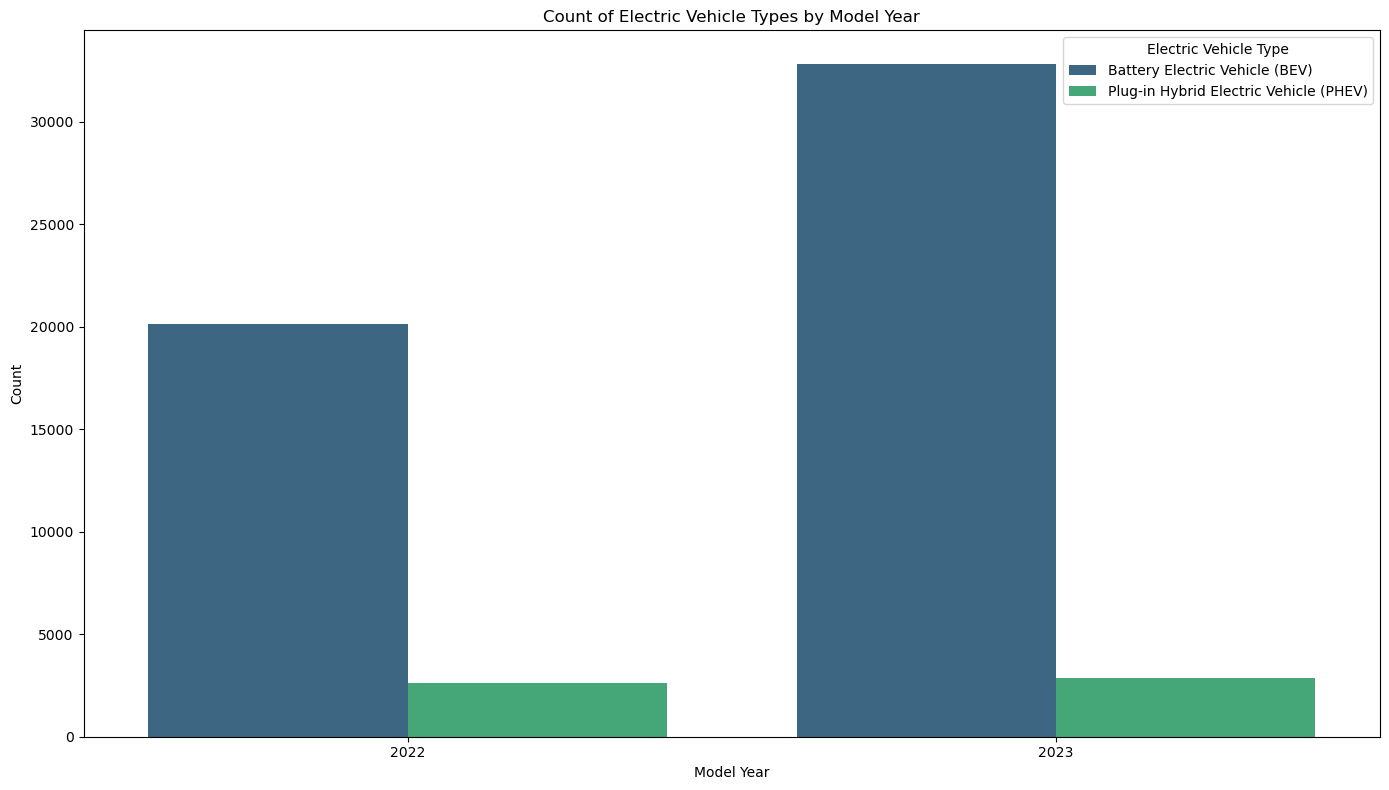

In [30]:
# Grouping by Make and Electric Vehicle Type, counting each group
grouped_data_unstack_evt = (
    filtered_df.groupby(['Model Year', 'Electric Vehicle Type'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
grouped_data_unstack_evt

# Setting up the figure
plt.figure(figsize=(14, 8))

# Using a stacked bar plot by melting the data for Seaborn
melted_data = grouped_data_unstack_evt.melt(id_vars='Model Year', var_name='Electric Vehicle Type', value_name='Count')

# Creating the bar plot
sns.barplot(data=melted_data, x='Model Year', y='Count', hue='Electric Vehicle Type', palette='viridis')

# Adding labels and title
plt.title('Count of Electric Vehicle Types by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Count')
plt.legend(title='Electric Vehicle Type', loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

### Insights:
- Cant compare with Electric Vehicle but we can not remove HYBRID car out of the market due to their flexibility and driver interest
- Slow Improve YOY

In [93]:
# Grouping by Make and Electric Vehicle Type, counting each group
grouped_data_unstack = (
    filtered_df.groupby(['Make', 'Electric Vehicle Type'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
grouped_data_unstack

Electric Vehicle Type,Make,Battery Electric Vehicle (BEV),Plug-in Hybrid Electric Vehicle (PHEV)
0,BMW,1206,1384
1,CHEVROLET,3147,0
2,FORD,3235,296
3,KIA,2987,1533
4,MERCEDES-BENZ,838,0
5,NISSAN,2135,0
6,TESLA,35866,0
7,TOYOTA,178,1158
8,VOLKSWAGEN,2361,0
9,VOLVO,1020,1102


### Insights:
- Not all Car Makes are interested in HYBRID market
- VOLVO, FORD, KIA, TOYOTA, VOLVO

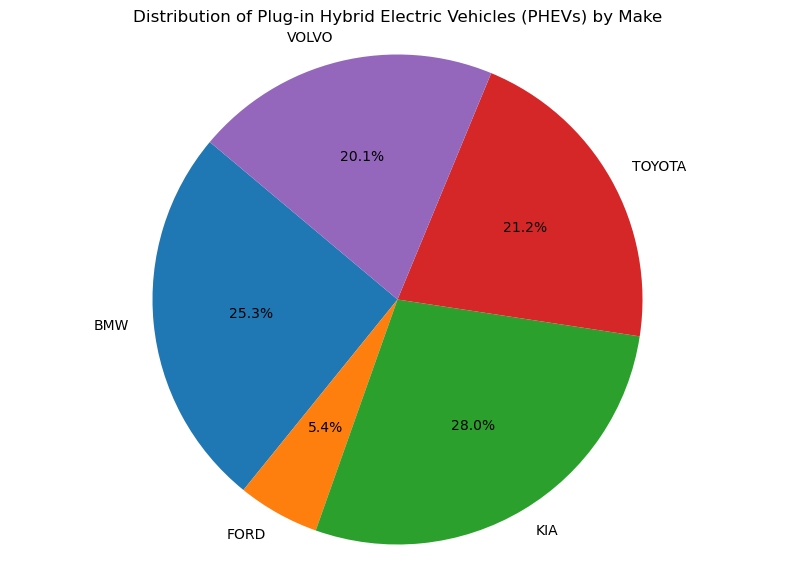

In [95]:
# Filter for only the Plug-in Hybrid Electric Vehicles (PHEV)
phev_data = grouped_data_unstack[['Make', 'Plug-in Hybrid Electric Vehicle (PHEV)']].copy()

# Filter where PHEV count is greater than 0
phev_data = phev_data[phev_data['Plug-in Hybrid Electric Vehicle (PHEV)'] > 0]

# Rename the count column for clarity
phev_data.rename(columns={'Plug-in Hybrid Electric Vehicle (PHEV)': 'Count'}, inplace=True)

# Plotting the pie chart
plt.figure(figsize=(10, 7))
plt.pie(phev_data['Count'], labels=phev_data['Make'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Plug-in Hybrid Electric Vehicles (PHEVs) by Make')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()

### Insights:
- HYBRID market seems very balance
- KIA and BMW are top 2 HYBRID Car Make. 


## Overview:
- Electric Vehicle Market is boiling from 2022 to 2023
- Most Car Makes are selling higher than previous year. Some car makes also made over 100% in car sold YOY. Ex: VOLKSWAGEN, MERCEDES-BENZ	 and CHEVROLET
- Tesla with all models is dominating the Market in every sectors ( MKT Contribution, Electric Range) with the increase YOY 60% from 2022 to 2023.  
- EV attracts mostly Higher Social Classes. King County from Seattle and Bellevue city are top 2 cities with the most EV. 
- However, most Car Makes or Models are using Battery where Eligibility unknown as battery range has not been researched. Only EV from TOYOTA is using Cleanest Battery. This is also a question to political environment
- Although HYBRID car is not increasing sighnificant like Fully Battery car. This market slightly increasely from 2022 to 2023 in sales. The market contribution from each car make is fairly balance. However, based on preference, people still do not want to transfer fully to battery car. This market can become very competitive because it can bring a stable profit if any car makes can dominate in it. 